<a href="https://colab.research.google.com/github/DGkurnia/discuss1/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#libary import
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd  # Untuk load & mengolah tabel/CSV/Excel/Gsheet
import numpy as np   # Numpy in Array
import matplotlib.pyplot as plt
import seaborn as sns
import shutil   #managing ZIP files
from datetime import datetime # for managing time-related date
#importing tables
dfcustomer = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/DicodingCollection/customers.csv")
dforder = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/DicodingCollection/orders.csv")
dfproduct = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/DicodingCollection/products.csv")
dfsale = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/DicodingCollection/sales.csv")
#inspecting each df
dfsale.head(10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sales_id,order_id,product_id,price_per_unit,quantity,total_price
0,0,1,218,106,2,212.0
1,1,1,481,118,1,118.0
2,2,1,2,96,3,288.0
3,3,1,1002,106,2,212.0
4,4,1,691,113,3,339.0
5,5,1,981,106,3,318.0
6,6,2,915,96,1,96.0
7,7,2,686,113,1,113.0
8,8,2,1091,115,3,345.0
9,9,2,1196,105,1,NaN


1. Preparing dataset

2. Fixing Missing values

In [ ]:
#inspecting missing data
dfcustomer.info()
dforder.info()
tnacol = dfcustomer.isna().sum()
print(tnacol)
print("Jumlah duplikasi: ", dfcustomer.duplicated().sum())
print("Jumlah duplikasi: ",dforder.duplicated().sum())
dforder.describe()
dfproduct.info()
print("Jumlah duplikasi: ", dfproduct.duplicated().sum())
dfproduct.describe()
dfsale.isna().sum()

"""
oke, sampai tahap ini, kita telah berhasil mengidentifikasi berbagai masalah pada data yang telah kita kumpulkan. Berikut merupakan rangkumannya.


Tipe data

Missing value (Terdapat 18 missing values pada kolom gender di
customer_df.)

Duplicate data (Terdapat 6 data yang duplikat.)

Inaccurate value Terdapat inaccurate value pada kolom age.

orders_df

Terdapat kesalahan tipe data untuk kolom order_date & delivery_date di product_df

di sales_df

Terdapat 19 missing value pada kolom total_price.
"""

3. Handling mistakes in data

In [7]:
dfcustomer.drop_duplicates(inplace=True)
#print("Jumlah duplikasi: ", dfcustomer.duplicated().sum())
#dfcustomer segment
dfcustomer.gender.value_counts()
#dfcustomer[dfcustomer.gender.isna()]
dfcustomer.fillna(value="Prefer not to say", inplace=True)
#managing incorrect age
dfcustomer.age.replace(dfcustomer.age.max(), 70, inplace=True)
dfcustomer.age.replace(dfcustomer.age.max(), 50, inplace=True)
#dfcustomer.describe()
#order segment
datetime_columns = ["order_date", "delivery_date"]

for column in datetime_columns:
  dforder[column] = pd.to_datetime(dforder[column])
#dforder.info()
#product segment
dfproduct.drop_duplicates(inplace=True)
#print("Jumlah duplikasi: ", dfproduct.duplicated().sum())
#sale segment
dfsale[dfsale.total_price.isna()]
dfsale["total_price"] = dfsale["price_per_unit"] * dfsale["quantity"]
dfsale.isna().sum()

,0
sales_id,0
order_id,0
product_id,0
price_per_unit,0
quantity,0
total_price,0


4. Describing code

In [ ]:
#describibng data
#dfcustomer.describe(include="all")
dfcustomer.groupby(by="gender").agg({
    "customer_id": "nunique",
    "age": ["max", "min", "mean", "std"]
})
#segmenting
dfcustomer.groupby(by="city").customer_id.nunique().sort_values(ascending=False)
dfcustomer.groupby(by="state").customer_id.nunique().sort_values(ascending=False)

describing data - part 2

In [ ]:
#intro
delivery_time = dforder["delivery_date"] - dforder["order_date"]
delivery_time = delivery_time.apply(lambda x: x.total_seconds())
dforder["delivery_time"] = round(delivery_time/86400)
#inspecting
#print(dforder["delivery_time"])
#customer inspection
customer_id_in_orders_df =  dforder.customer_id.tolist()
dfcustomer["status"] = dfcustomer["customer_id"].apply(lambda x: "Active" if x in customer_id_in_orders_df else "Non Active")
dfcustomer.groupby(by="status").customer_id.count()
#merging dataset
orders_customers_df = pd.merge(
    left= dforder,
    right= dfcustomer,
    how="left",
    left_on="customer_id",
    right_on="customer_id"
)
orders_customers_df.head()

Pivot segmentation

In [ ]:
#city-based pivot
orders_customers_df.groupby(by="city").order_id.nunique().sort_values(ascending=False).reset_index().head(10)
#state based pivot
orders_customers_df.groupby(by="state").order_id.nunique().sort_values(ascending=False)
#gender based
orders_customers_df.groupby(by="gender").order_id.nunique().sort_values(ascending=False)
#age based group
orders_customers_df["age_group"] = orders_customers_df.age.apply(lambda x: "Youth" if x <= 24 else ("Seniors" if x > 64 else "Adults"))
orders_customers_df.groupby(by="age_group").order_id.nunique().sort_values(ascending=False)

product and sales

In [11]:
#sales prediction (phase 1)
dfproduct.sort_values(by="price", ascending=False)
#pivot in sales and product
dfproduct.groupby(by="product_type").agg({
    "product_id": "nunique",
    "quantity": "sum",
    "price":  ["min", "max"]
})

#determining
dfproduct.groupby(by="product_name").agg({
    "product_id": "nunique",
    "quantity": "sum",
    "price": ["min", "max"]
})
#merging the dataset
sales_product_df = pd.merge(
    left= dfsale,
    right= dfproduct,
    how="left",
    left_on="product_id",
    right_on="product_id"
)
sales_product_df.head(10)

,sales_id,order_id,product_id,price_per_unit,quantity_x,total_price,product_type,product_name,size,colour,price,quantity_y,description
0,0,1,218,106,2,212,Shirt,Chambray,L,orange,105,44,"A orange coloured, L sized, Chambray Shirt"
1,1,1,481,118,1,118,Jacket,Puffer,S,indigo,110,62,"A indigo coloured, S sized, Puffer Jacket"
2,2,1,2,96,3,288,Shirt,Oxford Cloth,M,red,114,54,"A red coloured, M sized, Oxford Cloth Shirt"
3,3,1,1002,106,2,212,Trousers,Wool,M,blue,111,52,"A blue coloured, M sized, Wool Trousers"
4,4,1,691,113,3,339,Jacket,Parka,S,indigo,119,53,"A indigo coloured, S sized, Parka Jacket"
5,5,1,981,106,3,318,Trousers,Wool,S,red,111,65,"A red coloured, S sized, Wool Trousers"
6,6,2,915,96,1,96,Trousers,Drawstring,XS,orange,104,41,"A orange coloured, XS sized, Drawstring Trousers"
7,7,2,686,113,1,113,Jacket,Parka,S,blue,119,72,"A blue coloured, S sized, Parka Jacket"
8,8,2,1091,115,3,345,Trousers,Cropped,S,orange,99,78,"A orange coloured, S sized, Cropped Trousers"
9,9,2,1196,105,1,105,Trousers,Pleated,S,orange,90,72,"A orange coloured, S sized, Pleated Trousers"


Pivot table from sales and products

In [12]:
#preparing pivot from product typer
sales_product_df.groupby(by="product_type").agg({
    "sales_id": "nunique",
    "quantity_x": "sum",
    "total_price": "sum"
})
#preparing pivot from name
sales_product_df.groupby(by="product_name").agg({
    "sales_id": "nunique",
    "quantity_x": "sum",
    "total_price": "sum"
}).sort_values(by="total_price", ascending=False)

,sales_id,quantity_x,total_price
product_name,,,
Denim,273,527,52399
Casual Slim Fit,154,306,36414
Trench Coat,146,299,35581
Shearling,150,302,35334
Puffer,140,298,35164
Flannel,141,281,33158
Cropped,135,284,32660
Pleated,147,308,32340
Joggers,164,334,31062


Merging all dataset

In [ ]:
#first step
all_df = pd.merge(
    left = sales_product_df,
    right = orders_customers_df,
    how="left",
    left_on="order_id",
    right_on="order_id"
)
#all_df.head(10)
all_df.groupby(by=["state", "product_type"]).agg({
    "quantity_x": "sum",
    "total_price": "sum"
})
all_df.groupby(by=["gender", "product_type"]).agg({
    "quantity_x": "sum",
    "total_price": "sum"
})

all_df.groupby(by=["age_group", "product_type"]).agg({
    "quantity_x": "sum",
    "total_price": "sum"
})

Visualisation

In [ ]:
#initial
monthly_orders_df = all_df.resample(rule='M', on='order_date').agg({
    "order_id": "nunique",
    "total_price": "sum"
})
monthly_orders_df.index = monthly_orders_df.index.strftime('%Y-%m')
monthly_orders_df = monthly_orders_df.reset_index()
monthly_orders_df.rename(columns={
    "order_id": "order_count",
    "total_price": "revenue"
}, inplace=True)
#monthly_orders_df.head()
#displaying chart
monthly_orders_df = all_df.resample(rule='M', on='order_date').agg({
    "order_id": "nunique",
    "total_price": "sum"
})
monthly_orders_df.index = monthly_orders_df.index.strftime('%B') #mengubah format order date menjadi nama bulan

monthly_orders_df = monthly_orders_df.reset_index()
monthly_orders_df.rename(columns={
    "order_id": "order_count",
    "total_price": "revenue"
}, inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(monthly_orders_df["order_date"], monthly_orders_df["order_count"], marker='o', linewidth=2, color="#72BCD4")
plt.title("Number of Orders per Month (2021)", loc="center", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Detailed chart for revenue

In [ ]:
#displaying size
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_orders_df["order_date"],
    monthly_orders_df["revenue"],
    marker='o',
    linewidth=2,
    color="#72BCD4"
)
plt.title("Total Revenue per Month (2021)", loc="center", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

determining the most and the least amount of program

In [ ]:
#the most and least amount product
sum_order_items_df = all_df.groupby("product_name").quantity_x.sum().sort_values(ascending=False).reset_index()
sum_order_items_df.head(15)

ilustrating the results

<ipython-input-21-fb585b0eea3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="quantity_x", y="product_name", data = sum_order_items_df.head(5), palette=colors, ax=ax[0])
<ipython-input-21-fb585b0eea3d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.sort_values(by="quantity_x", ascending=True).head(5), palette=colors, ax=ax[1])


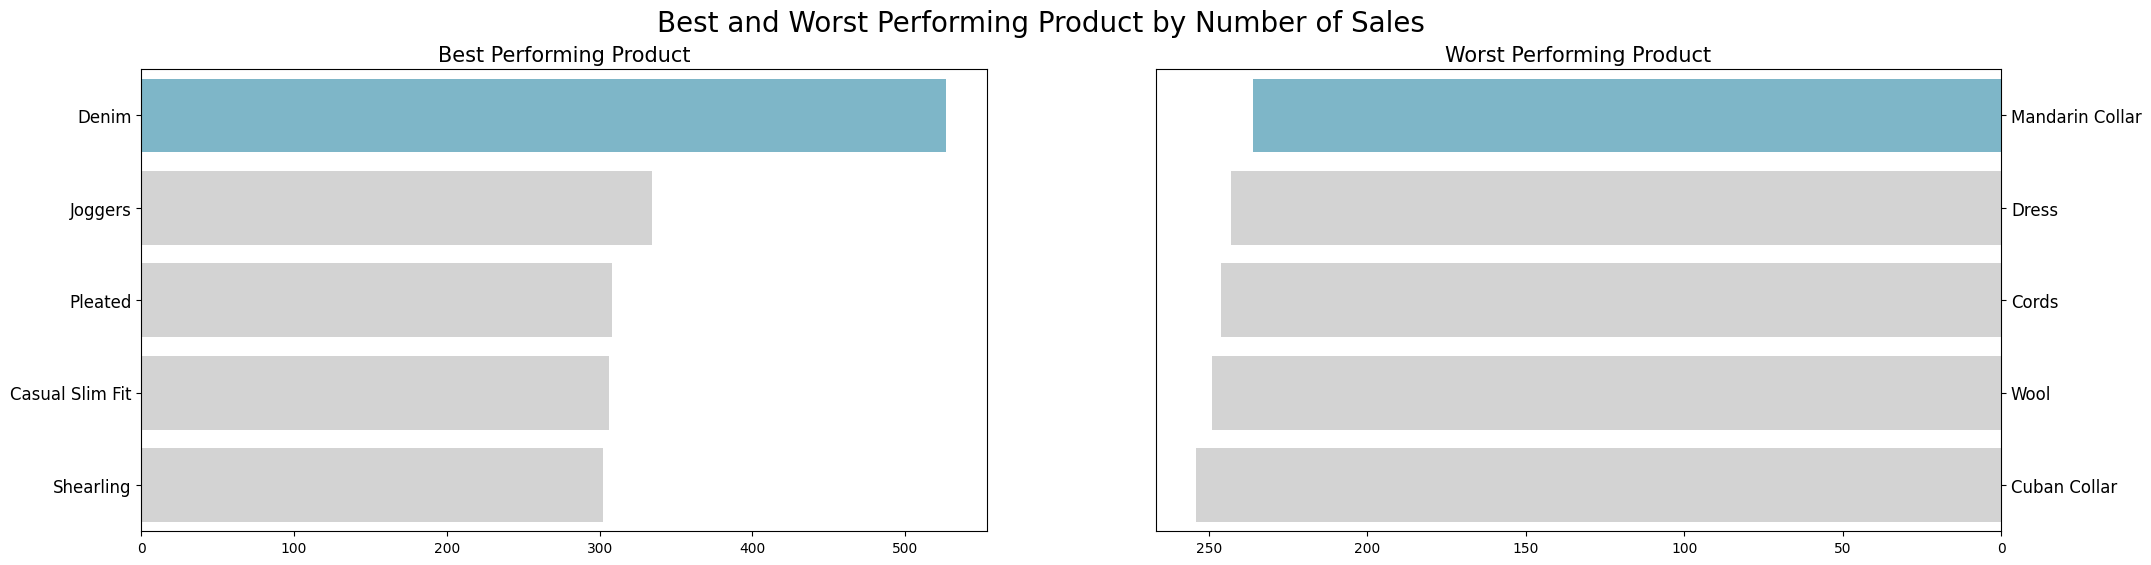

In [21]:
#code to illustrate the progress
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(x="quantity_x", y="product_name", data = sum_order_items_df.head(5), palette=colors, ax=ax[0])

ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.sort_values(by="quantity_x", ascending=True).head(5), palette=colors, ax=ax[1])

ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Best and Worst Performing Product by Number of Sales", fontsize=20)
plt.show()

<ipython-input-22-47e3e259f3ea>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-22-47e3e259f3ea>:9: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(


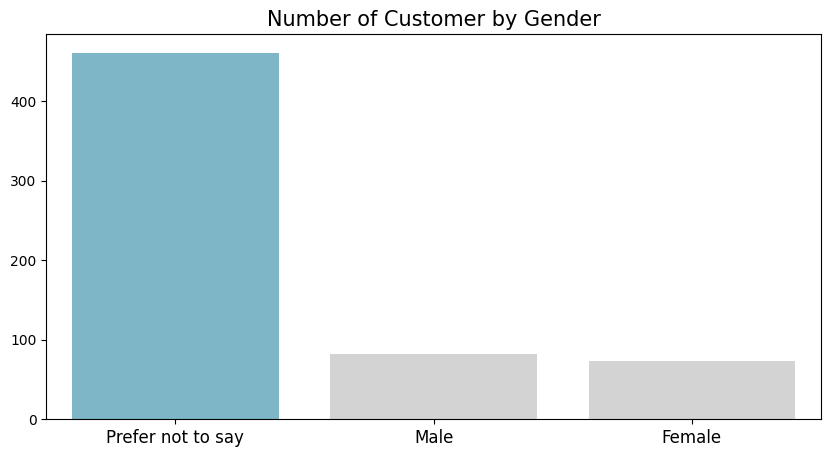

In [22]:
#Customer Demography
bygender_df = all_df.groupby(by="gender").customer_id.nunique().reset_index()
bygender_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)

plt.figure(figsize=(10, 5))

sns.barplot(
    y="customer_count",
    x="gender",
    data=bygender_df.sort_values(by="customer_count", ascending=False),
    palette=colors
)
plt.title("Number of Customer by Gender", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=12)
plt.show()

Age based information

<ipython-input-23-996c608ed9a9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-23-996c608ed9a9>:11: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(


<Axes: xlabel='age_group', ylabel='customer_count'>

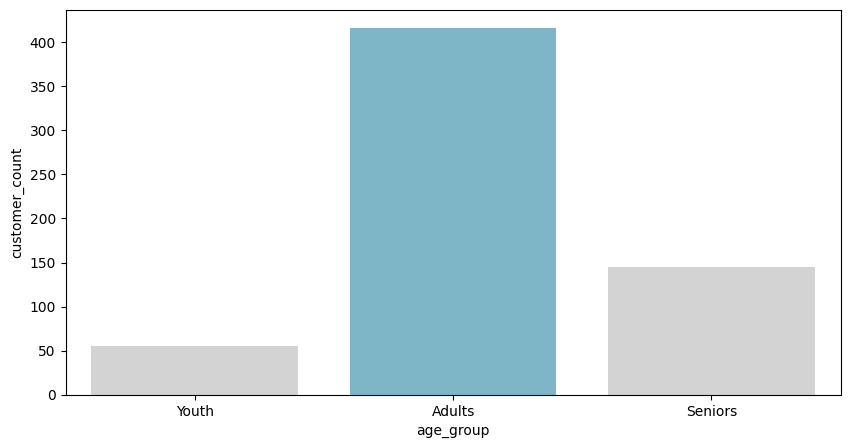

In [23]:
#chart
byage_df = all_df.groupby(by="age_group").customer_id.nunique().reset_index()
byage_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)
byage_df
byage_df['age_group'] = pd.Categorical(byage_df['age_group'], ["Youth", "Adults", "Seniors"])
plt.figure(figsize=(10, 5))
colors_ = ["#D3D3D3", "#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(
    y="customer_count",
    x="age_group",
    data=byage_df.sort_values(by="age_group", ascending=False),
    palette=colors_
)

state-based

In [ ]:
#state-based
bystate_df = all_df.groupby(by="state").customer_id.nunique().reset_index()
bystate_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)
bystate_df
plt.figure(figsize=(10, 5))
colors_ = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(
    x="customer_count",
    y="state",
    data=bystate_df.sort_values(by="customer_count", ascending=False),
    palette=colors_
)
plt.title("Number of Customer by States", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='y', labelsize=12)
plt.show()

RFM Analysis

In [ ]:
#first component of RFM analysis
rfm_df = all_df.groupby(by="customer_id", as_index=False).agg({
    "order_date": "max", # mengambil tanggal order terakhir
    "order_id": "nunique", # menghitung jumlah order
    "total_price": "sum" # menghitung jumlah revenue yang dihasilkan
})
rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]

# menghitung kapan terakhir pelanggan melakukan transaksi (hari)
rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
recent_date = dforder["order_date"].dt.date.max()
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

rfm_df.drop("max_order_timestamp", axis=1, inplace=True)
rfm_df.head()

second part of RFM

<ipython-input-27-24b78f2f868e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
<ipython-input-27-24b78f2f868e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
<ipython-input-27-24b78f2f868e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="

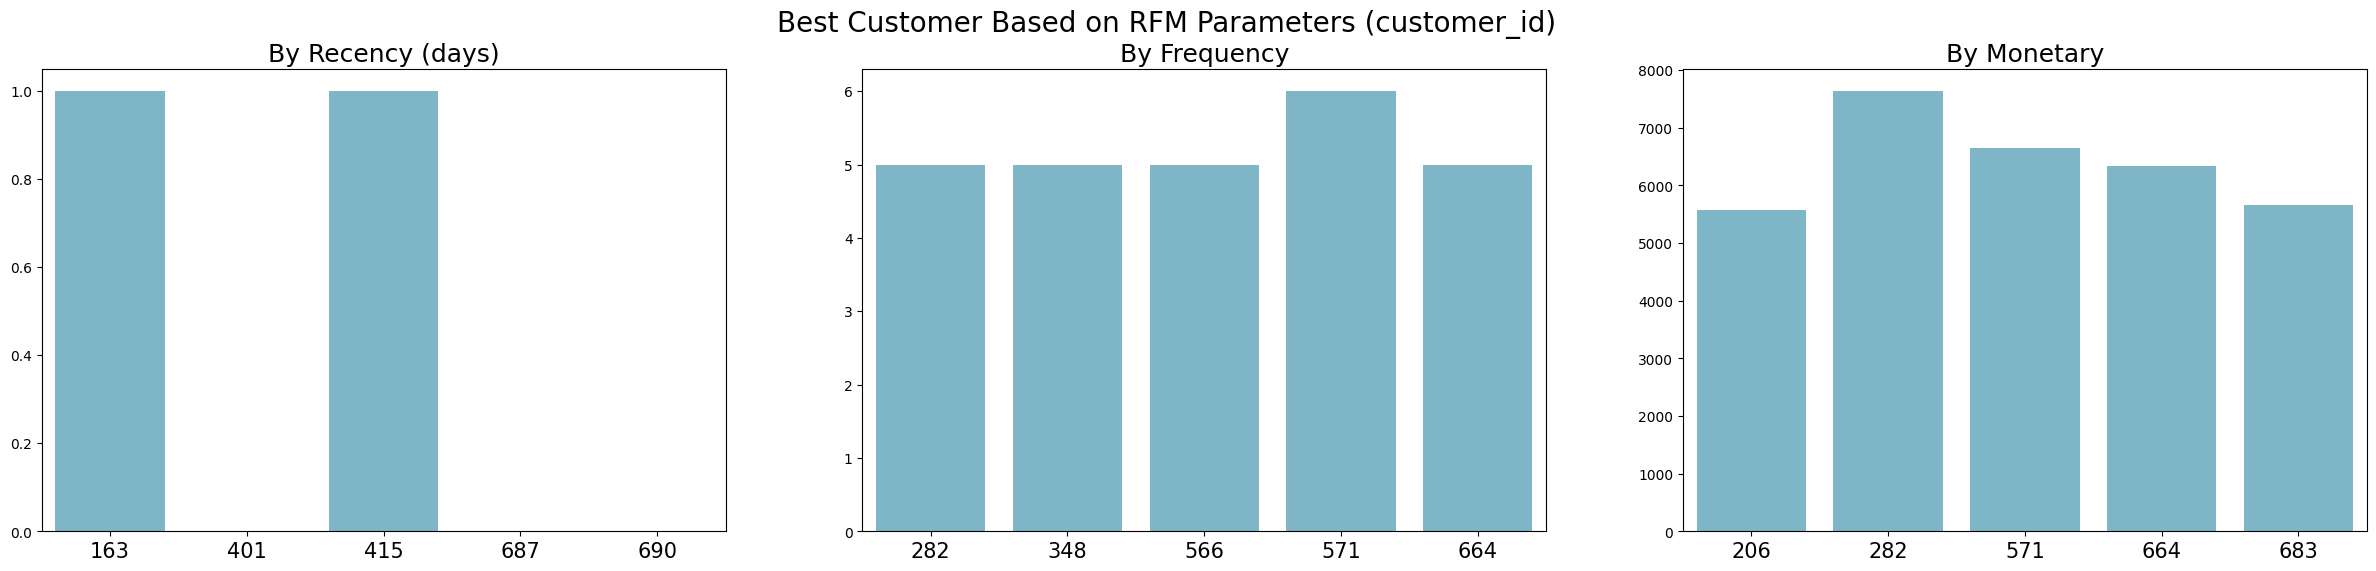

In [27]:
#second part
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=15)

sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15)

sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2])
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=15)

plt.suptitle("Best Customer Based on RFM Parameters (customer_id)", fontsize=20)
plt.show()